In [1]:
try:
  import diffusers
except Exception:
  !pip install torch torchvision matplotlib tqdm einops datasets \
diffusers==0.31.0 transformers==4.43.3 huggingface_hub==0.23.5 accelerate==0.31.0

In [2]:
import math
import os
import time
from tqdm import trange, tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

from diffusers import UNet2DModel
from diffusers import DDPMScheduler, DDIMScheduler

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


### Part 1: Linear Noise Schedule and Forward Noising

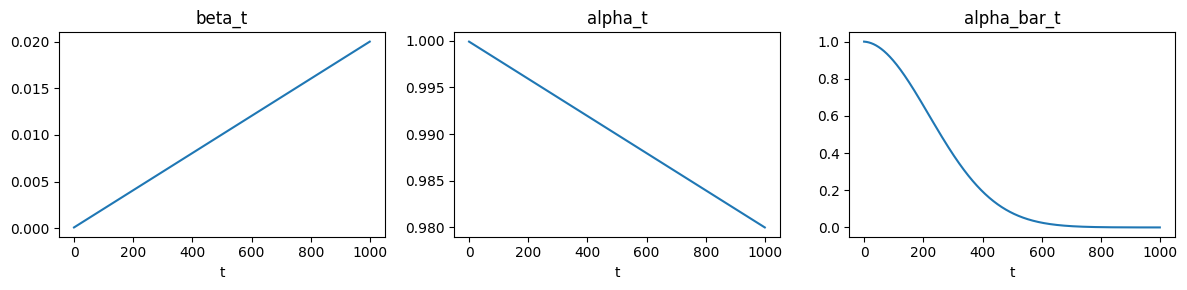

In [3]:
T = 1000
beta_start = 1e-4
beta_end = 2e-2

# linear schedule
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float64)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

betas = betas.float().to(device)
alphas = alphas.float().to(device)
alpha_bars = alpha_bars.float().to(device)

# Plot beta, alpha, alpha_bar
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(betas.cpu().numpy())
plt.title('beta_t')
plt.xlabel('t')

plt.subplot(1,3,2)
plt.plot(alphas.cpu().numpy())
plt.title('alpha_t')
plt.xlabel('t')

plt.subplot(1,3,3)
plt.plot(alpha_bars.cpu().numpy())
plt.title('alpha_bar_t')
plt.xlabel('t')

plt.tight_layout()
plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.94MB/s]


label 5


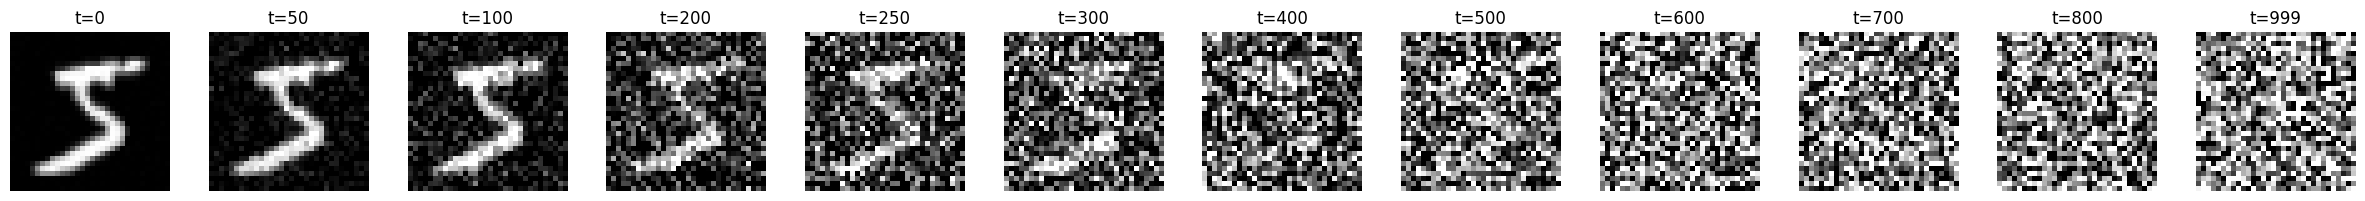

In [4]:
from matplotlib import cm

def add_noise_forward(x0, t, eps=None):
  if eps is None:
    eps = torch.randn_like(x0)
  a_bar = alpha_bars.to(x0.device)[t].view(-1,1,1,1)
  xt = torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * eps
  return xt

# Load a single MNIST image and show noisy versions at specific steps
transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)) # maps to [-1, 1]
])

mnist = datasets.MNIST(root='data', train=True, download=True, transform=transform)
img, label = mnist[0]
print('label', label)

steps = [0,50,100,200,250,300,400,500,600,700,800,999]
fig, axes = plt.subplots(1, len(steps), figsize=(2*len(steps),2))
for i,t in enumerate(steps):
  x0 = img.unsqueeze(0) # (1,1,32,32)
  xt = add_noise_forward(x0, torch.tensor([t], dtype=torch.long))
  im = xt.clamp(-1,1).squeeze().cpu().numpy()
  axes[i].imshow((im+1)/2, cmap='gray')
  axes[i].set_title(f't={t}')
  axes[i].axis('off')
plt.tight_layout()
plt.show()

### Part 2: Model and Schedulers (PyTorch Diffusers)

In [5]:
model = UNet2DModel(
sample_size=32,
in_channels=1+10,
out_channels=1,
layers_per_block=2,
block_out_channels=(32,64,128),
down_block_types=("DownBlock2D","DownBlock2D","DownBlock2D"),
up_block_types=("UpBlock2D","UpBlock2D","UpBlock2D"),
)

model.to(device)
print('Model params:', sum(p.numel() for p in model.parameters()))

Model params: 3610753


In [6]:
print(model)

UNet2DModel(
  (conv_in): Conv2d(11, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ke

In [7]:
# Schedulers
ddpm = DDPMScheduler(
beta_start=beta_start,
beta_end=beta_end,
beta_schedule="linear",
num_train_timesteps=T,
prediction_type="sample"
)

ddim = DDIMScheduler.from_config(ddpm.config)

print("DDPM Scheduler:", ddpm)
print("DDIM Scheduler:", ddim)

DDPM Scheduler: DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.35.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "sample",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

DDIM Scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.35.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "sample",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_

In [8]:
B = 2
dummy_x = torch.randn(B, 1, 32, 32, device=device)
y = torch.tensor([3,7], dtype=torch.long, device=device)

import torch.nn.functional as F

def make_model_input(x, y, p_uncond=0.1):
  B,_,H,W = x.shape
  C = F.one_hot(y, 10).float().view(B,10,1,1).expand(B,10,H,W).to(x.device)
  m = (torch.rand(B, device=x.device) < p_uncond).float().view(B,1,1,1)
  C = C * (1.0 - m)
  return torch.cat([x, C.to(x.dtype)], dim=1)

Z = make_model_input(dummy_x, y, p_uncond=0.0)
# timesteps tensor
t_dummy = torch.tensor([10,200], dtype=torch.long, device=device)

out = model(Z, t_dummy).sample
print('Model output shape:', out.shape)

Model output shape: torch.Size([2, 1, 32, 32])


### Part 3: Training (50 epochs) and Curve

In [9]:
from torch.optim import Adam

batch_size = 128
train_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True, drop_last=True)

opt = Adam(model.parameters(), lr=2e-4)

def train_one_epoch(model, ddpm, dataloader, opt, device, p_uncond=0.1, epoch=0, max_steps=None):
  model.train()
  total_loss = 0.0
  count = 0
  running = None
  progress = tqdm(dataloader, desc=f'Epoch {epoch}') if max_steps is None else tqdm(dataloader, total=max_steps, desc=f'Epoch {epoch}')
  steps = 0
  for X0, y in progress:
    X0 = X0.to(device)
    y = y.to(device)
    B = X0.size(0)
    t = torch.randint(0, ddpm.config.num_train_timesteps, (B,), device=device, dtype=torch.long)
    eps = torch.randn_like(X0)
    Xt = ddpm.add_noise(X0, eps, t)
    Zt = make_model_input(Xt, y, p_uncond=p_uncond)
    x0_hat = model(Zt, t).sample
    loss = F.mse_loss(x0_hat, X0)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    total_loss += float(loss.item()) * B
    count += B
    running = loss.item() if running is None else 0.98*running + 0.02*loss.item()
    progress.set_postfix({'avg_loss': total_loss / count, 'running': running})
    steps += 1
    if max_steps is not None and steps >= max_steps:
      break
  return total_loss / max(count,1)

In [10]:
epochs = 50
loss_history = []
for ep in range(epochs):
  avg = train_one_epoch(model, ddpm, train_loader, opt, device, p_uncond=0.1, epoch=ep)
  loss_history.append(avg)
  torch.save({'model_state': model.state_dict(), 'optimizer_state': opt.state_dict(), 'epoch': ep}, f'checkpoint_ep{ep}.pt')


Epoch 49: 100%|██████████| 468/468 [01:36<00:00,  4.87it/s, avg_loss=0.0939, running=0.0946]


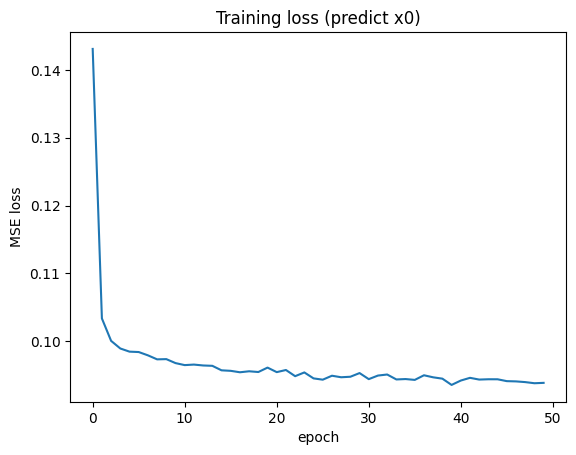

In [11]:
plt.figure()
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title('Training loss (predict x0)')
plt.show()

### Part 4: Visualizing x0 Across Noise

In [46]:
ckpt = torch.load("checkpoint_ep49.pt", map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()
print("Loaded trained weights from epoch", ckpt["epoch"])

Loaded trained weights from epoch 49


Conditional predictions (p_uncond=0)


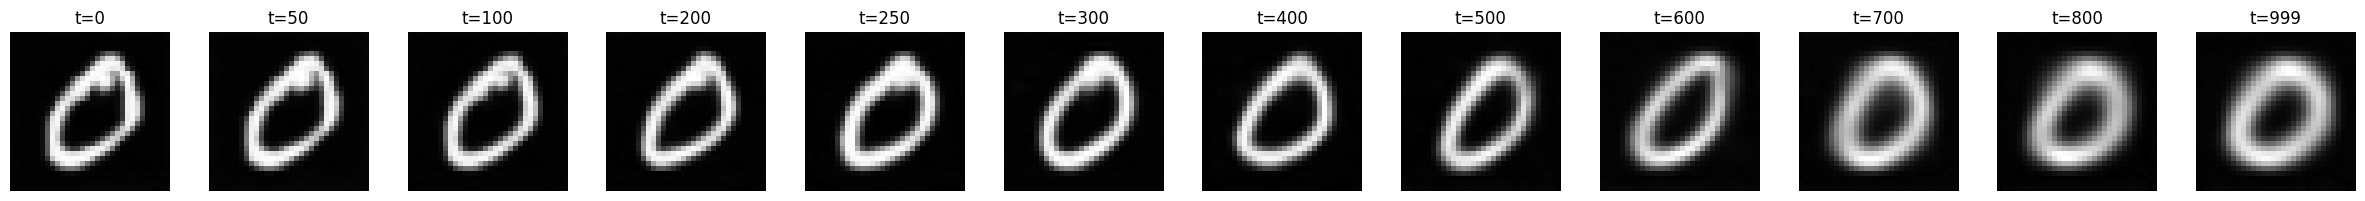

In [47]:
def predict_x0(model, xt, y, t, puncond=0.0):
    model.eval()
    with torch.no_grad():
        Z = make_model_input(xt, y, p_uncond=puncond)
        out = model(Z, t).sample
    return out

x0, y0 = mnist[1]
x0 = x0.unsqueeze(0).to(device)
label = torch.tensor([y0], device=device)

steps = [0, 50, 100, 200, 250, 300, 400, 500, 600, 700, 800, 999]

print("Conditional predictions (p_uncond=0)")
fig_cond, axes_cond = plt.subplots(1, len(steps), figsize=(2*len(steps), 2))

for i, t in enumerate(steps):
    t_tensor = torch.tensor([t], dtype=torch.long, device=device)
    eps = torch.randn_like(x0)
    xt = add_noise_forward(x0, t_tensor, eps=eps)
    x0_hat = predict_x0(model, xt, label, t_tensor, puncond=0.0)
    axes_cond[i].imshow(((x0_hat[0,0].cpu().numpy() + 1) / 2), cmap='gray')
    axes_cond[i].set_title(f"t={t}")
    axes_cond[i].axis('off')

plt.tight_layout()
plt.show()

Unconditional predictions (p_uncond=1)


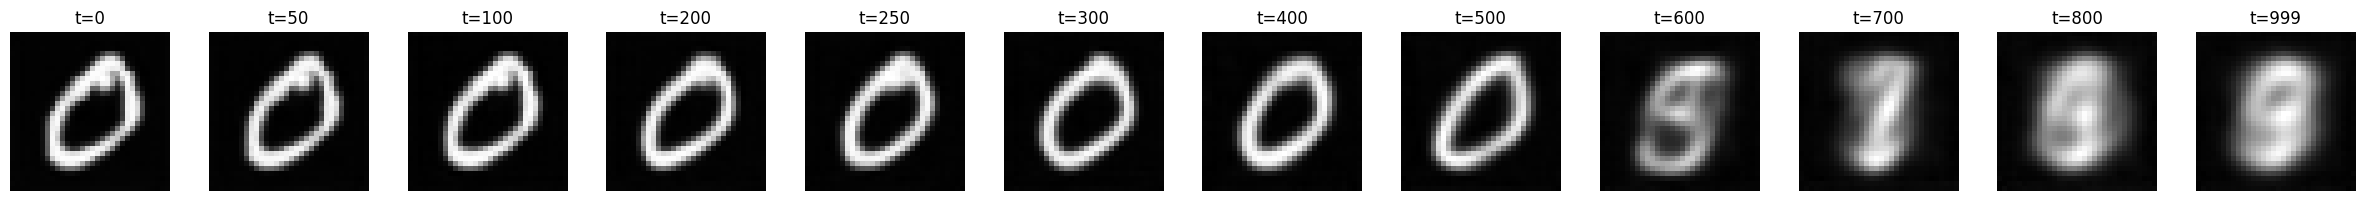

In [48]:
print("Unconditional predictions (p_uncond=1)")
fig_uncond, axes_uncond = plt.subplots(1, len(steps), figsize=(2*len(steps), 2))

for i, t in enumerate(steps):
    t_tensor = torch.tensor([t], dtype=torch.long, device=device)
    eps = torch.randn_like(x0)
    xt = add_noise_forward(x0, t_tensor, eps=eps)
    x0_hat = predict_x0(model, xt, label, t_tensor, puncond=1.0)
    axes_uncond[i].imshow(((x0_hat[0,0].cpu().numpy() + 1) / 2), cmap='gray')
    axes_uncond[i].set_title(f"t={t}")
    axes_uncond[i].axis('off')

plt.tight_layout()
plt.show()

### Part 5: Sampling — DDPM and DDIM with CFG

In [49]:
def class_maps(y, H=32, W=32):
  B = y.shape[0]
  return F.one_hot(y, 10).float().view(B,10,1,1).expand(B,10,H,W).to(device)

In [50]:
# DDPM sampling function with CFG
def sample_ddpm(model, ddpm, labels, guidance_scale=2.0):
  model.eval()
  ddpm.set_timesteps(ddpm.config.num_train_timesteps)
  B = labels.shape[0]
  X = torch.randn(B,1,32,32, device=device)
  with torch.no_grad():
    for t in tqdm(ddpm.timesteps, desc='DDPM sampling'):
        t_tensor = torch.tensor([t]*B, dtype=torch.long, device=device)
        # conditional
        Zc = torch.cat([X, class_maps(labels)], dim=1)
        x0_c = model(Zc, t_tensor).sample
        # unconditional
        Zu = torch.cat([X, torch.zeros_like(class_maps(labels))], dim=1)
        x0_u = model(Zu, t_tensor).sample
        x0_cfg = x0_c + guidance_scale * (x0_c - x0_u)
        step = ddpm.step(model_output=x0_cfg, timestep=t, sample=X)
        X = step.prev_sample
  return X

In [51]:
# DDIM sampling function with CFG (K steps, eta=0)
def sample_ddim(model, ddim, labels, K=50, guidance_scale=2.0, eta=0.0):
  model.eval()
  ddim.set_timesteps(num_inference_steps=K)
  B = labels.shape[0]
  X = torch.randn(B,1,32,32, device=device)
  with torch.no_grad():
      for t in tqdm(ddim.timesteps, desc='DDIM sampling'):
          t_tensor = torch.tensor([t]*B, dtype=torch.long, device=device)
          Zc = torch.cat([X, class_maps(labels)], dim=1)
          x0_c = model(Zc, t_tensor).sample
          Zu = torch.cat([X, torch.zeros_like(class_maps(labels))], dim=1)
          x0_u = model(Zu, t_tensor).sample
          x0_cfg = x0_c + guidance_scale * (x0_c - x0_u)
          step = ddim.step(model_output=x0_cfg, timestep=t, sample=X, eta=eta)
          X = step.prev_sample
  return X

In [52]:
rows = 10
cols = 8
labels_grid = torch.arange(0,10, device=device).unsqueeze(1).repeat(1,cols).view(-1)

# To visualize the grid:
def show_grid(samples, rows=10, cols=8):
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    idx = 0
    for r in range(rows):
        for c in range(cols):
            im = samples[idx].squeeze().cpu().numpy()
            axes[r,c].imshow((im+1)/2, cmap='gray')
            axes[r,c].axis('off')
            idx += 1
    plt.tight_layout()
    plt.show()

DDPM sampling: 100%|██████████| 1000/1000 [01:01<00:00, 16.14it/s]


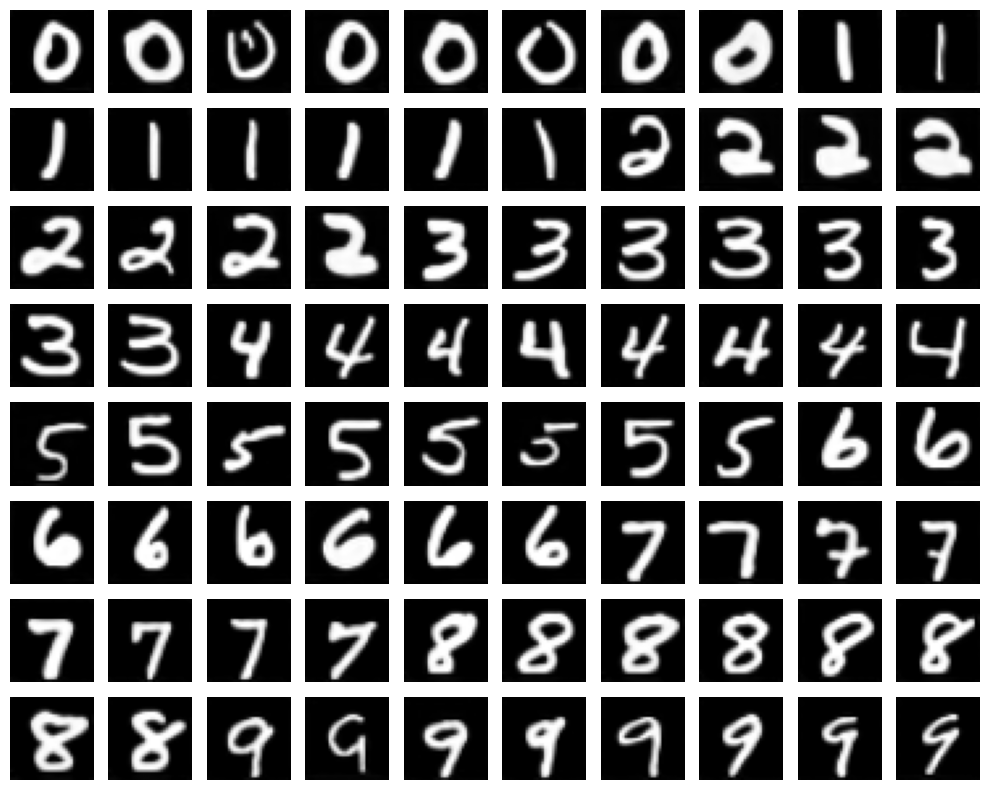

In [53]:
samples_ddpm = sample_ddpm(model, ddpm, labels_grid, guidance_scale=2.0)
show_grid(samples_ddpm, rows=8, cols=10)

DDIM sampling: 100%|██████████| 50/50 [00:03<00:00, 16.55it/s]


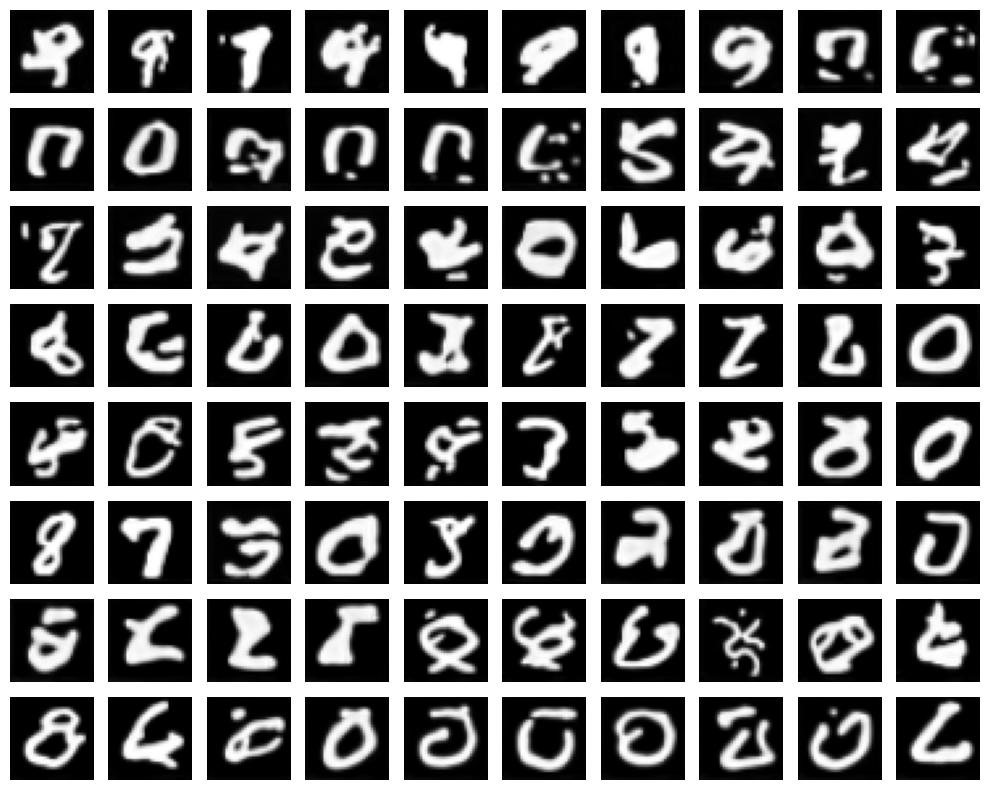

In [54]:
samples_ddim = sample_ddim(model, ddim, labels_grid, K=50, guidance_scale=2.0, eta=0.0)
show_grid(samples_ddim, rows=8, cols=10)